<a href="https://colab.research.google.com/github/sriharikrishna/siamcse21/blob/main/completed/perftest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tapenade mini benchmark

In this notebook we differentiate a small function with Tapenade in forward and reverse mode, then measure the run time of the obtained functions.

We use Tapenade and C for this. Apologies if the syntax highlighting for C is not perfect.

## Input function

This is a simple function that takes an input vector of size `n` and produces an output vector of size `m`. It performs a somewhat arbitrary computation internally.

In [26]:
%%writefile fun.c

void fun(int n, float a[n], int m, float b[m]) {
  float sum = 0.0;
  for(int i=0; i<n; i++) {
    sum += a[i]*a[i];
  }
  for(int i=0; i<m; i++) {
    b[i] = sum*i;
  }
}

Overwriting fun.c


## Forward Mode AD

This is the result of applying Tapenade in forward mode to the function above, choosing `a` as independent input and `b` as dependent output. If you modify the function, you will have to manually run Tapenade (through the command line or web interface), as this step is not integrated in this notebook.

In [27]:
%%writefile fun_d.c

/*        Generated by TAPENADE     (INRIA, Ecuador team)
    Tapenade 3.16 (develop) - 17 Dec 2020 10:03
*/
/*
  Differentiation of fun in forward (tangent) mode:
   variations   of useful results: b[0:m-1]
   with respect to varying inputs: a[0:n-1]
   RW status of diff variables: a:(loc) a[0:n-1]:in b:(loc) b[0:m-1]:out
   Plus diff mem management of: a:in b:in
*/
void fun_d(int n, float a[n], float ad[n], int m, float b[m], float bd[m]) {
    float sum = 0.0;
    float sumd;
    sumd = 0.0;
    {
      int ii1;
      for (int i = 0; i < n; ++i) {
          sumd = sumd + 2*a[i]*ad[i];
          sum += a[i]*a[i];
      }
      for (ii1 = 0; ii1 < m; ++ii1)
          bd[ii1] = 0.0;
    }
    for (int i = 0; i < m; ++i) {
        bd[i] = i*sumd;
        b[i] = sum*i;
    }
}

Overwriting fun_d.c


## Reverse Mode AD

This is the result of applying Tapenade in reverse mode to the function above, again choosing `a` as independent input and `b` as dependent output. If you run Tapenade and it generates code that uses the AD run time library (for example, it calls `pushInteger4(...)` or similar functions), then you will need to obtain the ADFirstAidKit from the Tapenade website, which contains these functions. You may not be able to use this within this notebook.

In [28]:
%%writefile fun_b.c

/*        Generated by TAPENADE     (INRIA, Ecuador team)
    Tapenade 3.16 (develop) - 17 Dec 2020 10:03
*/
#include <adBuffer.h>

/*
  Differentiation of fun in reverse (adjoint) mode:
   gradient     of useful results: b[0:m-1]
   with respect to varying inputs: a[0:n-1] b[0:m-1]
   RW status of diff variables: a:(loc) a[0:n-1]:out b:(loc) b[0:m-1]:in-out
   Plus diff mem management of: a:in b:in
*/
void fun_b(int n, float a[n], float ab[n], int m, float b[m], float bb[m]) {
    float sum = 0.0;
    float sumb = 0.0;
    for (int i = 0; i < n; ++i)
        sum = sum + a[i]*a[i];
    for (int i = 0; i < m; ++i)
        b[i] = sum*i;
    sumb = 0.0;
    for (int i = m-1; i > -1; --i) {
        sumb = sumb + i*bb[i];
        bb[i] = 0.0;
    }
    {
      int ii1;
      for (ii1 = 0; ii1 < n; ++ii1)
          ab[ii1] = 0.0;
      for (int i = n-1; i > -1; --i)
          ab[i] = ab[i] + 2*a[i]*sumb;
    }
}

Overwriting fun_b.c


## Driver

This driver takes the problem sizes from the terminal input, sets up the input and output vectors, and calls the function and its derivatives while measuring the time taken. It assembles the full Jacobian matrix of the function by seeding with the full set of cartesian basis vectors. You probably do not need to modify the driver.

In [29]:
%%writefile driver.c

#include <time.h>
#include <stdio.h>
#include <stdlib.h>

void fun(int n, float a[n], int m, float b[m]);
void fun_d(int n, float a[n], float ad[n], int m, float b[m], float bd[m]);
void fun_b(int n, float a[n], float ab[n], int m, float b[m], float bb[m]);

int main(int argc, char** argv) {
  /*
  Problem setup. Get input/output size, allocate memory, etc.
  */
  if(argc < 3) {
    printf("Usage: driver <num_inputs> <num_outputs>");
    return -1;
  }
  int n = atoi(argv[1]);
  int m = atoi(argv[2]);
  printf("===============================================\n");
  printf("Running function with %d inputs and %d outputs.\n",n,m);
  float* a = (float*)malloc(n*sizeof(float));
  float* a_seed = (float*)malloc(n*sizeof(float));
  for(int i=0; i<n; i++) {
    a[i] = (float)i;
    a_seed[i] = 0;
  }
  float* b = (float*)malloc(m*sizeof(float));
  float* b_seed = (float*)malloc(m*sizeof(float));
  for(int i=0; i<m; i++) {
    b_seed[i] = 0;
  }
  float* J_fwd = (float*)malloc(n*m*sizeof(float));
  float* J_rev = (float*)malloc(n*m*sizeof(float));
  clock_t tic, toc;
  double primaltime, difftime;

  /*
  Run the primal function and time it
  */
  tic = clock();
  fun(n, a, m, b);
  toc = clock() - tic;
  primaltime = (double)toc / (double)CLOCKS_PER_SEC;
  printf("primal time: %f\n", primaltime);

  printf("\nComputing one row/column of Jacobian:\n");
  /*
  Run the forward-mode once
  */
  tic = clock();
  a_seed[0] = 1.0;
  fun_d(n, a, a_seed, m, b, &J_fwd[0]);
  a_seed[0] = 0.0;
  toc = clock() - tic;
  difftime = (double)toc / (double)CLOCKS_PER_SEC;
  printf("forward Jv time: %f (factor: %f X)\n", difftime, difftime/primaltime);

  /*
  Run the reverse-mode once
  */
  tic = clock();
  b_seed[0] = 1.0;
  fun_b(n, a, &J_rev[0], m, b, b_seed);
  b_seed[0] = 0.0;
  toc = clock() - tic;
  difftime = (double)toc / (double)CLOCKS_PER_SEC;
  printf("reverse vJ time: %f (factor: %f X)\n", difftime, difftime/primaltime);

  printf("\nComputing the entire Jacobian:\n");
  /*
  Run the forward-mode n times (enough to obtain the entire Jacobian).
  */
  tic = clock();
  for(int i=0; i<n; i++) {
    a_seed[i] = 1.0;
    fun_d(n, a, a_seed, m, b, &J_fwd[i*m]);
    a_seed[i] = 0.0;
  }
  toc = clock() - tic;
  difftime = (double)toc / (double)CLOCKS_PER_SEC;
  printf("forward J time: %f (factor: %f X)\n", difftime, difftime/primaltime);

  /*
  Run the reverse-mode m times (enough to obtain the entire Jacobian).
  */
  tic = clock();
  for(int i=0; i<m; i++) {
    b_seed[i] = 1.0;
    fun_b(n, a, &J_rev[i*n], m, b, b_seed);
    b_seed[i] = 0.0;
  }
  toc = clock() - tic;
  difftime = (double)toc / (double)CLOCKS_PER_SEC;
  printf("reverse J time: %f (factor: %f X)\n", difftime, difftime/primaltime);

  /*
  Compare the computed Jacobians
  */
  for(int i=0; i<n; i++) {
    for(int j=0; j<m; j++) {
      if(J_fwd[i*m+j] != J_rev[j*n+i]) {
        printf("Jacobian from fwd and rev does not match!: %f != %f\n", J_fwd[i*m+j], J_rev[j*n+i]);
        return -1;
      }
    }
  }
  printf("Jacobian from fwd and rev matches!\n\n");

  free(a); free(b); free(a_seed); free(J_fwd); free(J_rev); free(b_seed);
  return 0;
}

Overwriting driver.c


## Compile

Compile our benchmark.

In [30]:
%%script bash

# if the AD runtime library is not yet loaded, download and compile it now.
if [ ! -f ADFirstAidKit/adBuffer.h ]; then
    wget tapenade.inria.fr:8080/tapenade/ADFirstAidKit.tar
    tar vxf ADFirstAidKit.tar
    (cd ADFirstAidKit && gcc -c -O3 -w adBuffer.c adStack.c adContext.c && ar -crs libAD.a *.o)
fi

# finally, install 
gcc -O3 -I./ADFirstAidKit -L./ADFirstAidKit fun.c fun_d.c fun_b.c driver.c -lAD -o perftest

## Run

Here we run the benchmark with just two settings: 1 input and 10000 outputs, and 10000 inputs and 1 output. This should highlight the differences between forward and reverse mode well.

In [31]:
%%script bash

./perftest 1 10000

Running function with 1 inputs and 10000 outputs.
primal time: 0.000019

Computing one row/column of Jacobian:
forward Jv time: 0.000024 (factor: 1.263158 X)
reverse vJ time: 0.000017 (factor: 0.894737 X)

Computing the entire Jacobian:
forward J time: 0.000006 (factor: 0.315789 X)
reverse J time: 0.179632 (factor: 9454.315789 X)
Jacobian from fwd and rev matches!



In [32]:
%%script bash

./perftest 10000 1

Running function with 10000 inputs and 1 outputs.
primal time: 0.000017

Computing one row/column of Jacobian:
forward Jv time: 0.000015 (factor: 0.882353 X)
reverse vJ time: 0.000036 (factor: 2.117647 X)

Computing the entire Jacobian:
forward J time: 0.176558 (factor: 10385.764706 X)
reverse J time: 0.000029 (factor: 1.705882 X)
Jacobian from fwd and rev matches!



## Running the benchmark for a range of input and output sizes

No need to understand this in detail. We loop over some input and output sizes, and filter the output of perftest to get only the overhead factors. We store all of them in `timings.txt`, which we will plot in the next field.

In [33]:
%%script bash
echo "" > timings.txt
for N_IN in 1 1000 2000 3000 4000 5000
do
  for N_OUT in 1 1000 2000 3000 4000 5000
  do
    OUTPUT=$(./perftest $N_IN $N_OUT)
    TIME_FWD=$(grep "forward J time" <<< "$OUTPUT" | awk '{print $6}')
    TIME_REV=$(grep "reverse J time" <<< "$OUTPUT" | awk '{print $6}')
    echo "$N_IN $N_OUT $TIME_FWD $TIME_REV" >> timings.txt
  done
done

wc -l timings.txt

37 timings.txt


## Plotting the time overhead factors
We use Python for this. Read `timings.txt` and generate a plot.

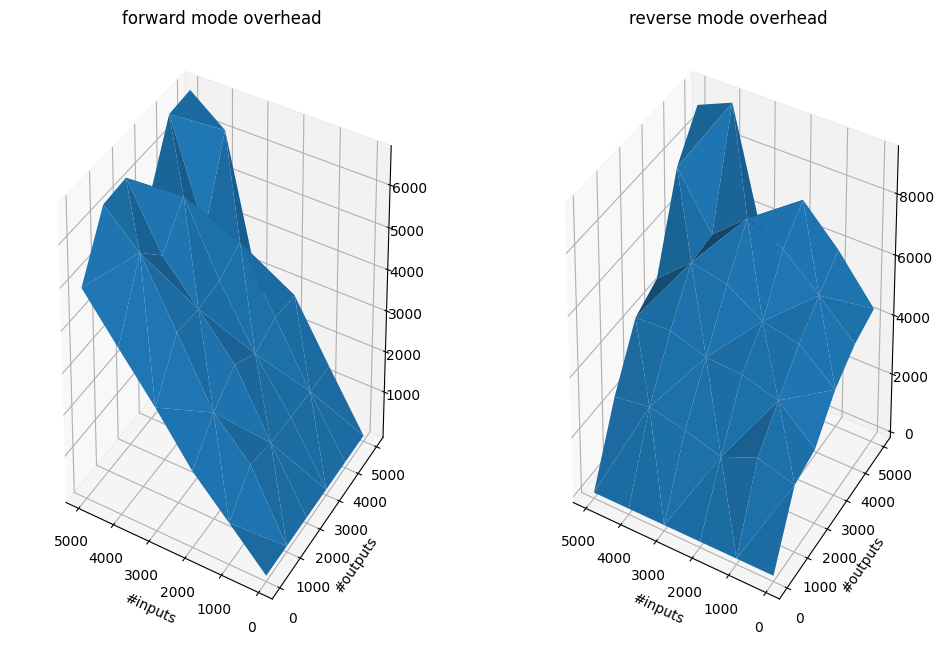

In [34]:
import numpy as np
import matplotlib.pyplot as plt
time_data = np.genfromtxt('timings.txt', delimiter=' ')

n_vec = time_data[:,0]
m_vec = time_data[:,1]
fwd_time = time_data[:,2]
rev_time = time_data[:,3]

fig, (ax0,ax1) = plt.subplots(subplot_kw={"projection": "3d"}, nrows=1, ncols=2, figsize=(12,8), dpi= 100)
for ax in (ax0,ax1):
  ax.set_xlabel('#inputs')
  ax.set_ylabel('#outputs')
  ax.invert_yaxis()
ax0.plot_trisurf(n_vec,m_vec,fwd_time)
ax1.plot_trisurf(n_vec,m_vec,rev_time)
ax0.title.set_text('forward mode overhead')
ax1.title.set_text('reverse mode overhead')

def plot_fun(ax, n_vals, m_vals, times, maxval, title=None):
  # Plot the surface.
  X, Y = np.meshgrid(list(n_vals.keys()), list(m_vals.keys()))
  surf = ax.plot_surface(X, Y, times, cmap=cm.coolwarm,
                        antialiased=True)
  # Customize the z  axis.
  ax.set_zlim(0, maxval*1.1)

  coordsn = list(n_vals.keys())
  ax.set_xticks(coordsn, ["$4^{:d}$".format(i) for i in coordsn])
  
  coordsm = list(m_vals.keys())
  ax.set_yticks(coordsm, ["$4^{:d}$".format(i) for i in coordsm])
  
  ax.invert_yaxis()
  
  ax.title.set_text(title)
  ax.set_xlabel('#inputs')
  ax.set_ylabel('#outputs')

# Exercises

Here are some ideas to try out:


1.   Change the number of inputs and outputs and observe how the run times and overhead factors change for forward and reverse mode.
2.   Re-run the same setting a few times. The notebook run times are a little noisy, probably you will get slightly different numbers each time.
2.   Change the function `fun` to something you actually want to compute (make sure the function header stays the same if you want to leave the rest of the notebook as is). You will need to use Tapenade to obtain the derivative functions `fun_d` and `fun_b` yourself, as the notebook does not automate this step.

